# Trafic sign classification

### Import requirements

In [15]:
import random
!pip install numpy pandas matplotlib seaborn pillow
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: C:\Users\dwisn\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


Looking in indexes: https://download.pytorch.org/whl/cu121



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: C:\Users\dwisn\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
sns.set()

### Load dataset

In [3]:
train_dir = './trafic_sign_dataset/Train'
test_dir = './trafic_sign_dataset'
meta_dir = './trafic_sign_dataset/Meta'
test_label_csv = './trafic_sign_dataset/Test_data.csv'

In [4]:
filepaths = []
labels = []

for label in os.listdir(train_dir):
    labelpath = os.path.join(train_dir, label)
    for f in os.listdir(labelpath):
        fpath = os.path.join(labelpath, f)
        filepaths.append(fpath)
        labels.append(label)

In [5]:
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)
test_df = pd.read_csv(test_label_csv)
test_df.columns = ['labels', 'filepaths']
test_df['filepaths'] = test_df['filepaths'].apply(lambda x: os.path.join(test_dir, x))
test_df['labels'] = test_df['labels'].apply(lambda x: str(x))

In [24]:
df.head()

filepaths labels
0  ./trafic_sign_dataset/Train\0\00000_00000_0000...      0
1  ./trafic_sign_dataset/Train\0\00000_00000_0000...      0
2  ./trafic_sign_dataset/Train\0\00000_00000_0000...      0
3  ./trafic_sign_dataset/Train\0\00000_00000_0000...      0
4  ./trafic_sign_dataset/Train\0\00000_00000_0000...      0

## Dataset analysis

## Train dataset

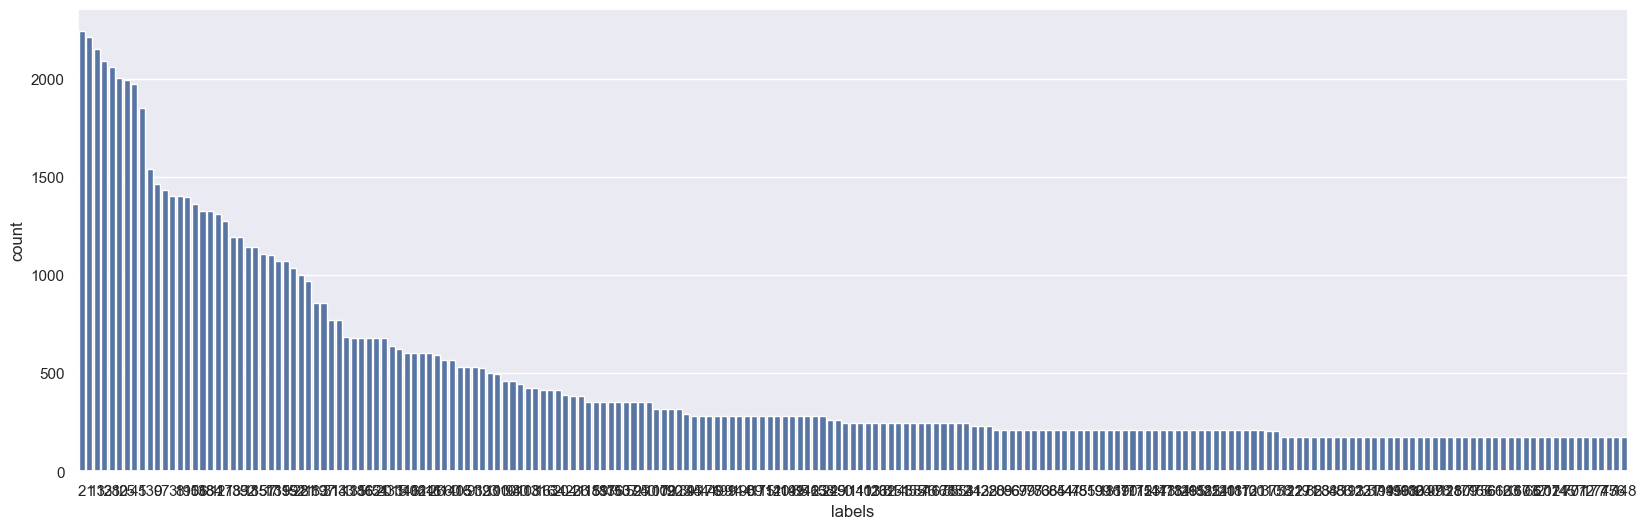

In [6]:
fig = plt.figure(figsize=(20,6))
ax = sns.countplot(x=df['labels'],
                   order=df['labels'].value_counts(ascending=False).index);

# abs_values = df['labels'].value_counts(ascending=False).values

# ax.bar_label(container=ax.containers[0], labels=abs_values)

In [7]:
max_labels = df['labels'].value_counts(ascending=False).iloc[0]
min_labels = df['labels'].value_counts(ascending=True).iloc[0]

print(f"Max value of element in single label: {max_labels}")
print(f"Min value of element in single label: {min_labels}")
print(f"Record count: {df.count()['labels']}")
print(f"Avg image group by label: {df.groupby('labels').count().mean()['filepaths']}")
print(f"Label count: {len(df['labels'].unique())}")
print(f"Label with max element count: {df['labels'].value_counts().idxmax()}")
print(f"Label with min element count: {df['labels'].value_counts().idxmin()}")

Max value of element in single label: 2243
Min value of element in single label: 173
Record count: 97426
Avg image group by label: 475.2487804878049
Label count: 205
Label with max element count: 2
Label with min element count: 58


Train dataset is unbalanced. For valid dataset we must pay attention to count elements by label. For training we would by select a random sample for each label, about 150 and repeat it for each epoch.

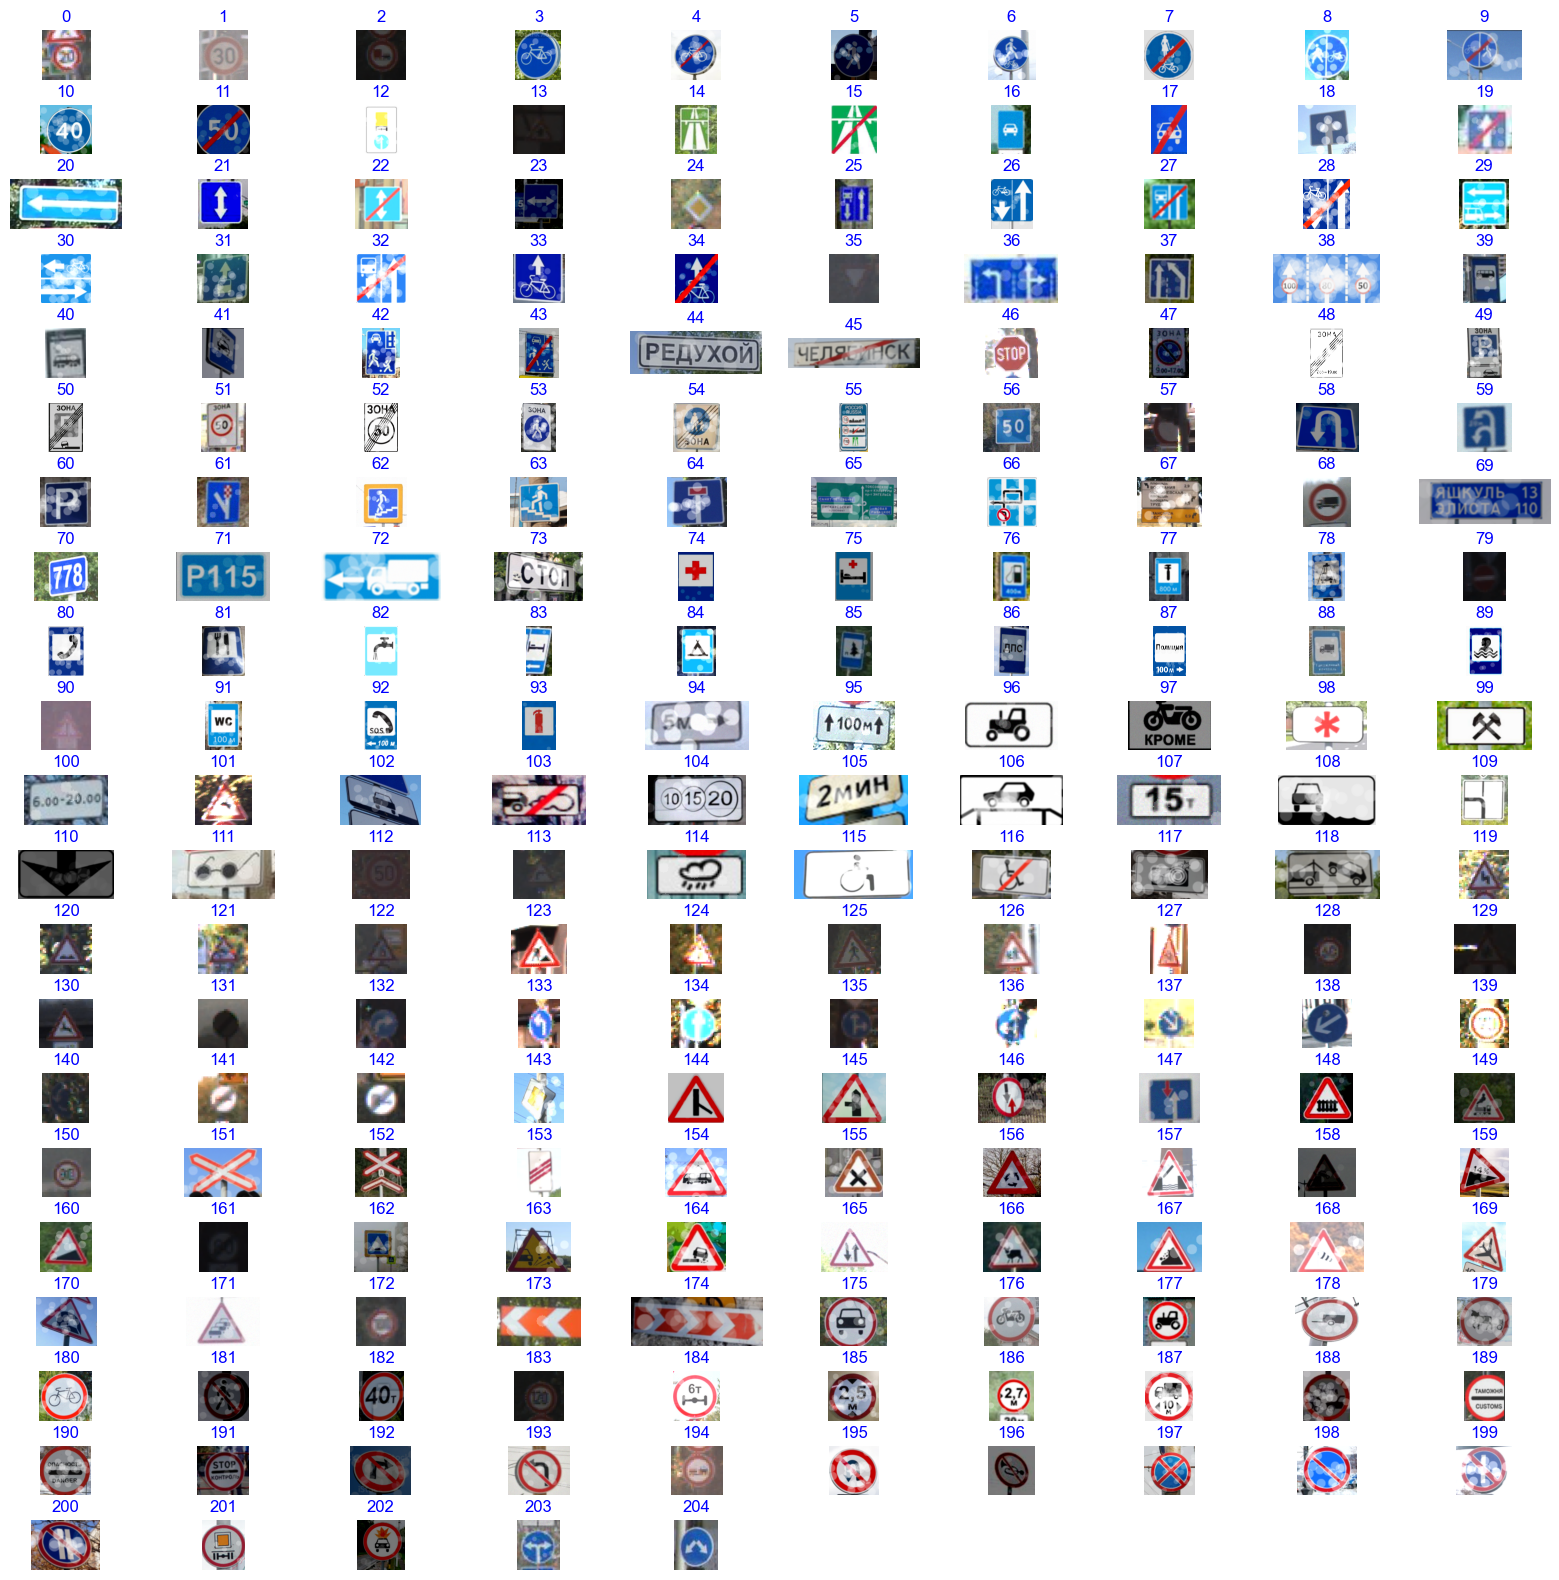

In [8]:
labels_list = df['labels'].unique()
plot_line = int(len(labels_list) / 10) + 1

sample_df = df.groupby('labels').first()
    
plt.figure(figsize=(20, 20))
for i in range(len(labels_list)):
    plt.subplot(plot_line, 10, i + 1)
    img_sample = sample_df.iloc[i]
    image = Image.open(img_sample['filepaths'])
    plt.imshow(image)
    plt.title(i, color='blue', fontsize=12)
    plt.axis('off')
plt.subplots_adjust(hspace=0.5)
plt.show()

## Test dataset

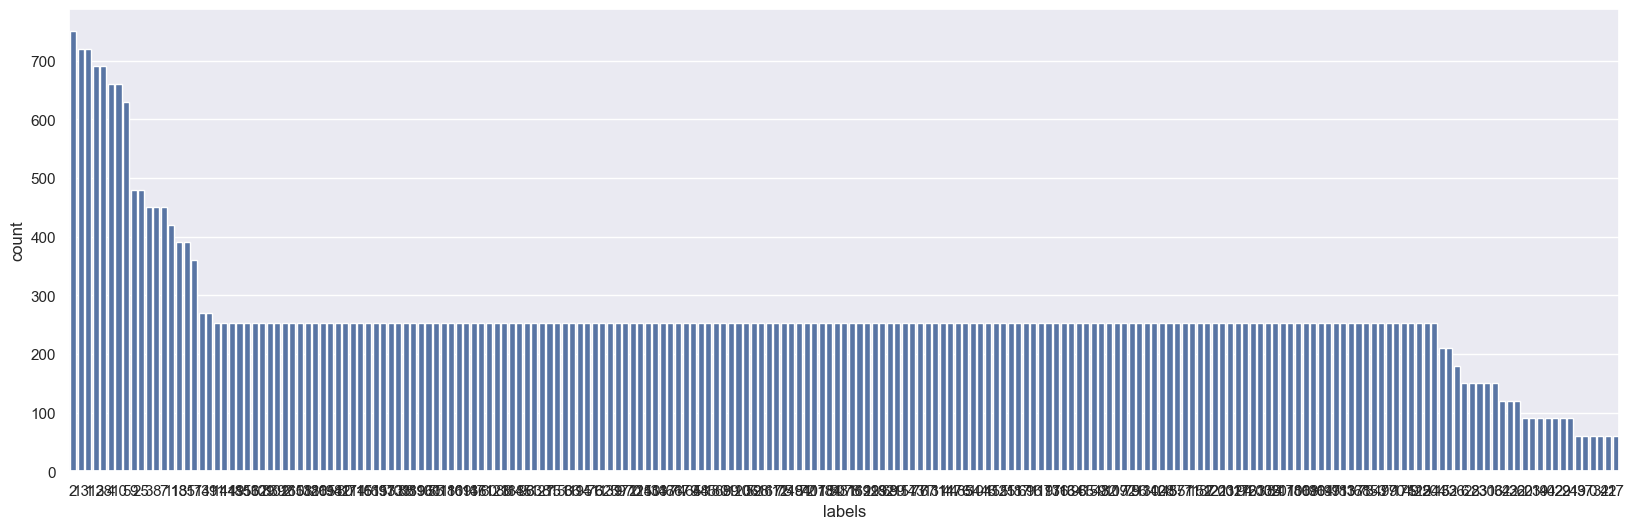

In [9]:
fig = plt.figure(figsize=(20,6))
ax = sns.countplot(x=test_df['labels'],
                   order=test_df['labels'].value_counts(ascending=False).index);

In [10]:
max_labels = test_df['labels'].value_counts(ascending=False).iloc[0]
min_labels = test_df['labels'].value_counts(ascending=True).iloc[0]

print(f"Max value of element in single label: {max_labels}")
print(f"Min value of element in single label: {min_labels}")
print(f"Record count: {test_df.count()['labels']}")
print(f"Avg image group by label: {test_df.groupby('labels').count().mean()['filepaths']}")
print(f"Label count: {len(test_df['labels'].unique())}")
print(f"Label with max element count: {test_df['labels'].value_counts().idxmax()}")
print(f"Label with min element count: {test_df['labels'].value_counts().idxmin()}")

Max value of element in single label: 750
Min value of element in single label: 60
Record count: 53454
Avg image group by label: 260.7512195121951
Label count: 205
Label with max element count: 2
Label with min element count: 19


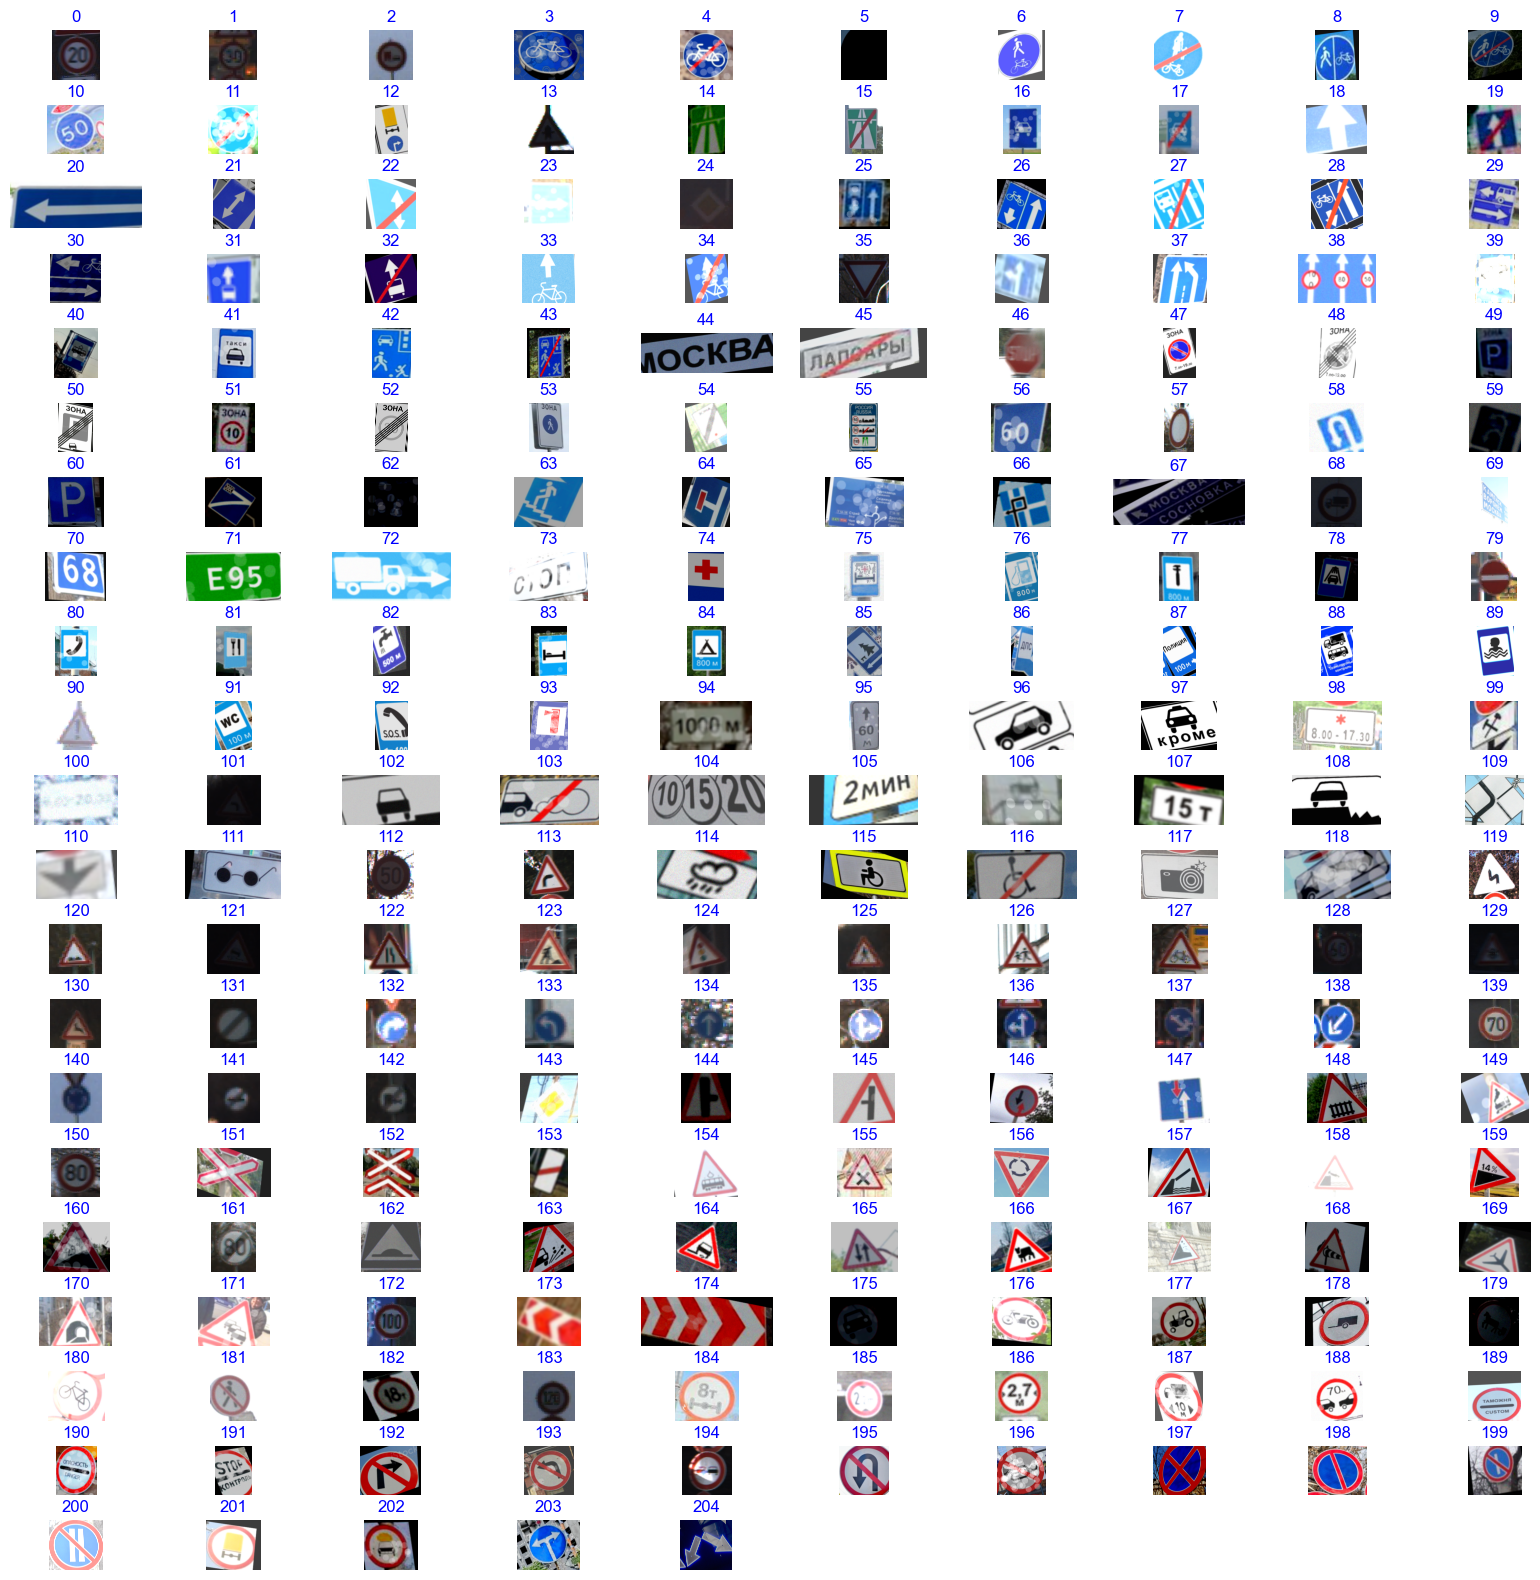

In [11]:
labels_list = test_df['labels'].unique()
plot_line = int(len(labels_list) / 10) + 1

sample_df = test_df.groupby('labels').first()
    
plt.figure(figsize=(20, 20))
for i in range(len(labels_list)):
    plt.subplot(plot_line, 10, i + 1)
    img_sample = sample_df.iloc[i]
    image = Image.open(img_sample['filepaths'])
    plt.imshow(image)
    plt.title(i, color='blue', fontsize=12)
    plt.axis('off')
plt.subplots_adjust(hspace=0.5)
plt.show()

Test dataset also is unbalanced, for testing our model we take 20 random sample per label.

In [12]:
for path in list(df['filepaths'].sample(5)):
    img = Image.open(path)
    img_np = np.array(img)
    print(img_np.shape)

(62, 67, 4)
(289, 310, 4)
(405, 452, 4)
(98, 92, 3)
(435, 490, 4)


Image has different size and color depth. So we must  normalize it before training our model.

In [81]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2
from torchvision.io import read_image
from torchvision.utils import make_grid
from torch.utils.data import Dataset
import random

In [20]:
print(torch.__version__)

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
 
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
       
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

2.3.0+cu121
Is CUDA supported by this system? True
CUDA version: 12.1
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce RTX 3060 Ti


In [21]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

# Datasets

In [110]:
class TrainDataset(Dataset):
    def __init__(self, img_dir, max_samples_per_class=None, transform=None, target_transform=None, device='cpu'):
        super(self.__class__, self).__init__()
        
        self.transform = transform
        self.target_transform = target_transform
        self.img_dir = img_dir
        self.device = device
        
        _filepaths = []
        _labels = []
        
        for label in os.listdir(train_dir):
            labelpath = os.path.join(train_dir, label)
            files = os.listdir(labelpath)
            if max_samples_per_class is not None:
                if len(files) > max_samples_per_class:
                    files = random.sample(files, max_samples_per_class)
            for f in files:
                _filepaths.append(f)
                _labels.append(label)
                
        _Fseries = pd.Series(_filepaths)
        _Lseries = pd.Series(_labels)
        self.img_labels = pd.concat([_Fseries, _Lseries], axis=1)
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1], self.img_labels.iloc[idx, 0])
        image = read_image(img_path).to(self.device)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label
    
    

In [143]:
class TestDataset(Dataset):
    def __init__(self, csv_file, img_dir, max_samples_per_class=None, transform=None, target_transform=None, device='cpu'):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.device = device
        
        # Wczytanie danych z pliku CSV
        self.img_labels = pd.read_csv(csv_file)
  
        self.img_labels.columns = ['labels', 'path']
        self.img_labels['labels'] = self.img_labels['labels'].apply(lambda x: str(x))
        
        # Filtrujemy dane jeśli max_samples_per_class jest ustawione
        if max_samples_per_class is not None:
            # Grupujemy dane na podstawie etykiet i próbkujemy z każdej grupy
            self.img_labels = self.img_labels.groupby('labels', as_index=False).apply(
                lambda x: x.sample(min(len(x), max_samples_per_class))
            ).reset_index(drop=True)
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx]['path'])
        image = read_image(img_path).to(self.device)
        label = self.img_labels.iloc[idx]['labels']
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

In [144]:
train_dataset = TrainDataset(train_dir, device=device)
test_dataset = TestDataset(test_label_csv, test_dir, 20, device=device)

C:\Users\dwisn\AppData\Local\Temp\ipykernel_33652\8117652.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.img_labels = self.img_labels.groupby('labels', as_index=False).apply(


In [152]:
train_dataloader = DataLoader(train_dataset, shuffle=True)
test_dataloader = DataLoader(test_dataset, shuffle=True)

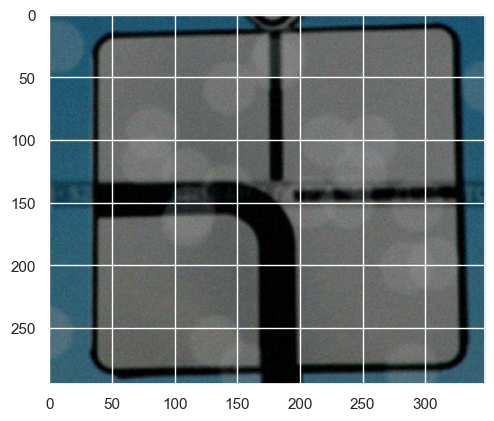

Label: 197
Shape: torch.Size([295, 348, 4])


In [153]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
img = train_features.to('cpu').squeeze().permute(1,2,0)
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")
print(f"Shape: {img.shape}")

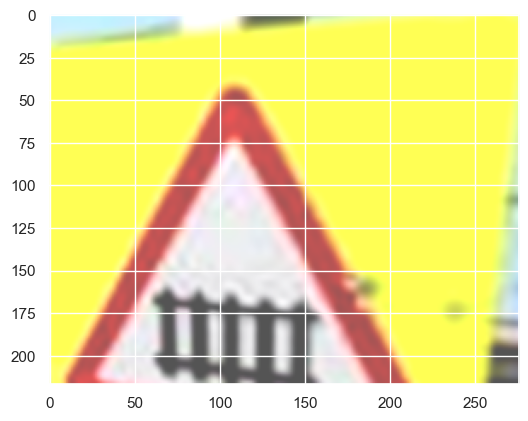

Label: 48
Shape: torch.Size([217, 276, 4])


In [155]:
# Display image and label.
test_features, test_labels = next(iter(test_dataloader))
img = test_features.to('cpu').squeeze().permute(1,2,0)
label = test_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")
print(f"Shape: {img.shape}")

In [66]:
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

heights = []
widths = []
channels = []

for images, _ in train_dataloader:
    # Dodajemy rozmiar każdego obrazu do list
    # images powinno mieć rozmiar (batch_size, channels, height, width)
    heights.append(images.size(2))
    widths.append(images.size(3))
    channels.append(images.size(1))

print(f'Analizowano {len(heights)} obrazów.')

Analizowano 97426 obrazów.


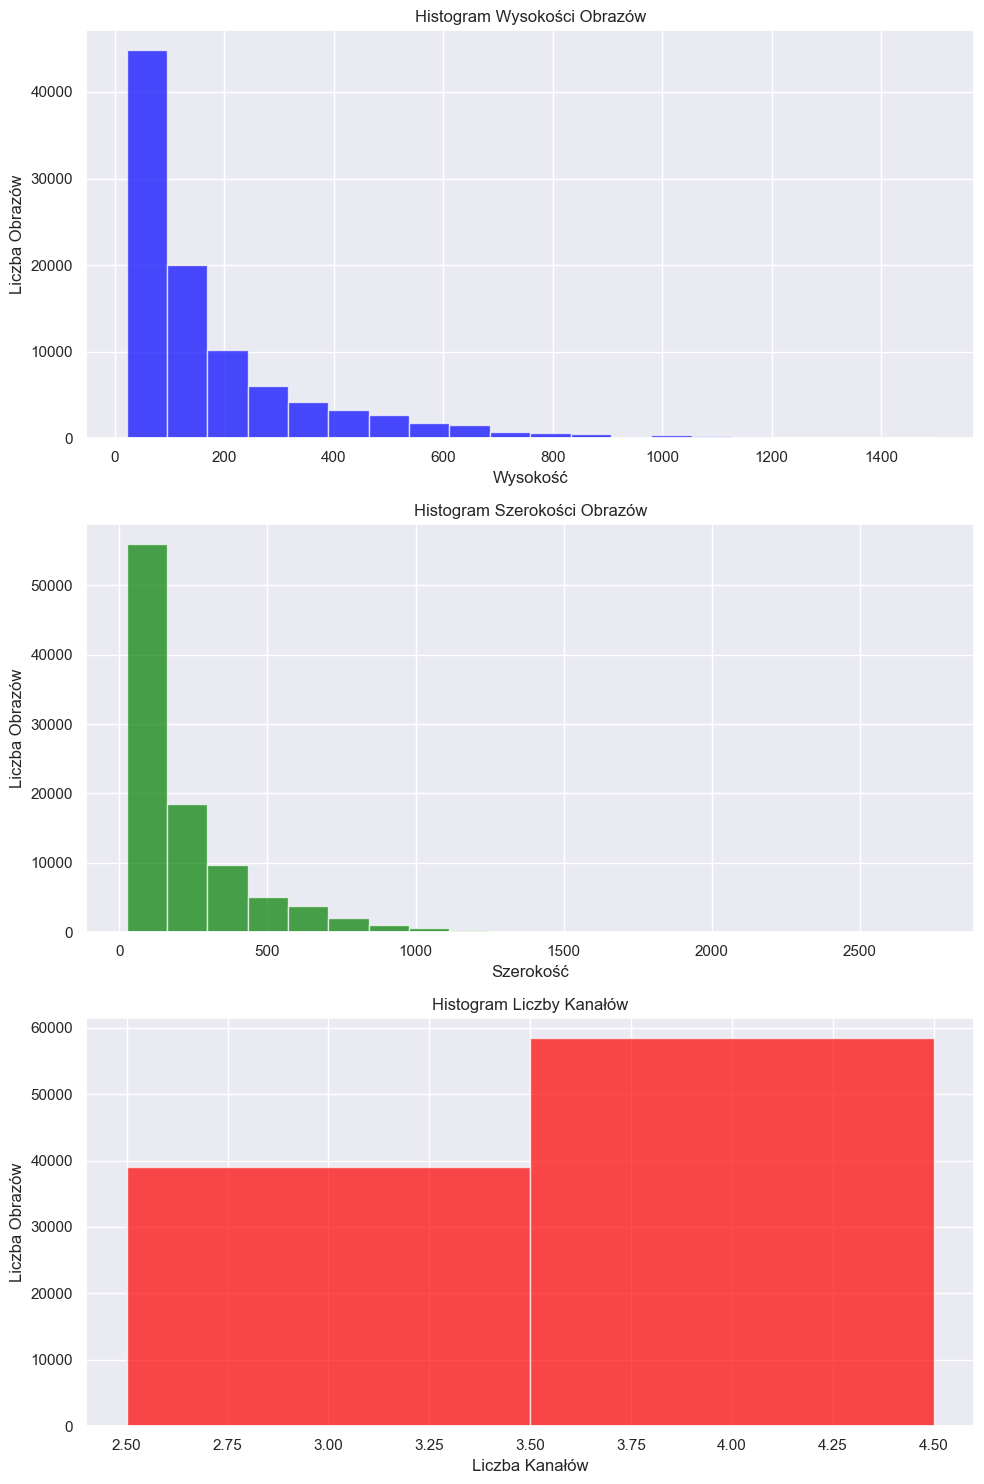

In [72]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Histogram wysokości
axs[0].hist(heights, bins=20, color='blue', alpha=0.7)
axs[0].set_title('Histogram Wysokości Obrazów')
axs[0].set_xlabel('Wysokość')
axs[0].set_ylabel('Liczba Obrazów')

# Histogram szerokości
axs[1].hist(widths, bins=20, color='green', alpha=0.7)
axs[1].set_title('Histogram Szerokości Obrazów')
axs[1].set_xlabel('Szerokość')
axs[1].set_ylabel('Liczba Obrazów')

# Histogram liczby kanałów
axs[2].hist(channels, bins=range(3, 6), align='left', color='red', alpha=0.7)
axs[2].set_title('Histogram Liczby Kanałów')
axs[2].set_xlabel('Liczba Kanałów')
axs[2].set_ylabel('Liczba Obrazów')

plt.tight_layout()
plt.show()

In [106]:
transform = v2.Compose([
    v2.ToPILImage(),
    v2.Resize((256, 256)),  # lub (200, 200) w zależności od wyboru
    v2.PILToTensor(),
    v2.Lambda(lambda x: x[:3, :, :] if x.shape[0] == 4 else x),
    v2.ConvertImageDtype(torch.float32),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

target_transform = int

In [107]:
train_dataset = TrainDataset(train_dir, 150, transform, target_transform, device=device)

In [160]:
import ipywidgets as widgets
from IPython.display import display

data_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
unique_labels_images = {}
num_classes = 205
for images, labels in data_loader:
    for image, label in zip(images, labels):
        label = label.item()  # zakładamy, że label to tensor
        if label not in unique_labels_images:
            # Zapisz pierwszy obraz dla każdej etykiety
            unique_labels_images[label] = image
        if len(unique_labels_images) == num_classes:  # num_classes to liczba klas
            break
    if len(unique_labels_images) == num_classes:
        break

# # Teraz mamy po jednym obrazie na label, wyświetlmy je
# images_grid = make_grid(list(unique_labels_images.values()), nrow=3)  # Adjust nrow as needed
# plt.figure(figsize=(15, 5))
# plt.imshow(images_grid.permute(1, 2, 0).to('cpu').numpy())
# plt.axis('off')
# plt.show()

def unnormalize(tensor):
    tensor = tensor * 0.5 + 0.5  # Przeskaluj z powrotem do [0, 1]
    return tensor

def view_images(index):
    grid = make_grid(list(unique_labels_images.values())[index:index+20], nrow=10)  # 20 obrazów na grid
    plt.figure(figsize=(10, 5))
    plt.imshow(unnormalize(grid).to('cpu').numpy().transpose((1, 2, 0)))
    plt.axis('off')
    plt.show()

# Utwórz slider do przewijania
slider = widgets.IntSlider(value=0, min=0, max=len(unique_labels_images.keys()) - 20, step=20, description='Start Index:')
widgets.interactive(view_images, index=slider)

interactive(children=(IntSlider(value=0, description='Start Index:', max=185, step=20), Output()), _dom_classe…

In [158]:
dataset = TrainDataset(train_dir, 150, transform, target_transform, device=device)
train_dataset, val_dataset = random_split(dataset, [0.8, 0.2])
test_dataset = TestDataset(test_label_csv, test_dir, 20, transform, target_transform, device=device)

C:\Users\dwisn\AppData\Local\Temp\ipykernel_33652\8117652.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.img_labels = self.img_labels.groupby('labels', as_index=False).apply(


In [159]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Wypisz informacje o wielkościach podziałów
print(f"Liczba rekordów w zbiorze treningowym: {len(train_dataset)}")
print(f"Liczba rekordów w zbiorze walidacyjnym: {len(val_dataset)}")
print(f"Liczba rekordów w zbiorze testowym: {len(test_dataset)}")

Liczba rekordów w zbiorze treningowym: 24600
Liczba rekordów w zbiorze walidacyjnym: 6150
Liczba rekordów w zbiorze testowym: 4100
